## Step 1: Insert a project token and run the inserted pretty code cell
<br/>A project *token* will allow you to access all the resources defined within this project.  By default, the token is inserted into the very first cell in a notebook.
<br/><img style="float: left;" src="https://github.com/yfphoon/dsx_local/blob/master/images/project_token.png?raw=true" alt="Project Token" />

In [29]:
# The code was removed by DSX for sharing.

hello Simon


In this notebook you will learn how to build a predictive model with Spark machine learning API (SparkML) to predict customer churn, and deploy it for scoring in Machine Learning (ML). 

This notebook walks you through these steps:
- Build a model with SparkML API
- Save the model in the ML repository
- Create a Deployment in ML (via UI)
- Test the model (via UI)
- Test the model (via REST API)
- add a comment

### Use Case

The analytics use case implemented in this notebook is telco churn. While it's a simple use case, it implements all steps from the CRISP-DM methodolody, which is the recommended best practice for implementing predictive analytics. 
![CRISP-DM](https://raw.githubusercontent.com/yfphoon/dsx_demo/master/crisp_dm.png)

The analytics process starts with defining the business problem and identifying the data that can be used to solve the problem. For Telco churn, we use demographic and historical transaction data. We also know which customers have churned, which is the critical information for building predictive models. In the next step, we use visual APIs for data understanding and complete some data preparation tasks. In a typical analytics project data preparation will include more steps (for example, formatting data or deriving new variables). 

Once the data is ready, we can build a predictive model. In our example we are using the SparkML Random Forrest classification model. Classification is a statistical technique which assigns a "class" to each customer record (for our use case "churn" or "no churn"). Classification models use historical data to come up with the logic to predict "class", this process is called model training. After the model is created, it's usually evaluated using another data set. 

Finally, if the model's accuracy meets the expectations, it can be deployed for scoring. Scoring is the process of applying the model to a new set of data. For example, when we receive new transactional data, we can score the customer for the risk of churn.  

We also developed a sample Python Flask application to illustrate deployment: http://predictcustomerchurn.mybluemix.net/. This application implements the REST client call to the model.

### Working with Notebooks

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. To run the notebook, it must be in the Edit mode. If you don't see the menu in the notebook, then it's not in the edit mode. Click on the pencil icon.
2. The notebook has 2 types of cells - markdown (text) and code. 
3. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
4. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
5. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

### Step 2: Load data 

In [9]:
# The code was removed by DSX for sharing.

In [30]:
print('hello Karolina!')


hello Marc


In [3]:
customer_churn.show(2)

+---+-----+
| ID|CHURN|
+---+-----+
|  1|    T|
|  6|    F|
+---+-----+
only showing top 2 rows



If the first step ran successfully (you saw the output), then continue reviewing the notebook and running each code cell step by step. Note that not every cell has a visual output. The cell is still running if you see a * in the brackets next to the cell. 

If the first step didn't finish successfully, check with the instructor. 

### Step 3: Merge Files

In [10]:
data=customer.join(customer_churn,customer['ID']==customer_churn['ID']).select(customer['*'],customer_churn['CHURN'])

### Step 4: Rename some columns
This step is to remove spaces from columns names, it's an example of data preparation that you may have to do before creating a model. 

In [11]:
data = data.withColumnRenamed("Est Income", "EstIncome").withColumnRenamed("Car Owner","CarOwner")
data.toPandas().head()

,ID,Gender,Status,Children,EstIncome,CarOwner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,CHURN
0,1,F,S,1,38000.00,N,24.393333,23.56,0,206.08,0,CC,Budget,Intnl_discount,229.64,3,T
1,6,M,M,2,29616.00,N,49.426667,29.78,0,45.50,0,CH,FreeLocal,Standard,75.29,2,F
2,8,M,M,0,19732.80,N,50.673333,24.81,0,22.44,0,CC,FreeLocal,Standard,47.25,3,F
3,11,M,S,2,96.33,N,56.473333,26.13,0,32.88,1,CC,Budget,Standard,59.01,1,F
4,14,F,M,2,52004.80,N,25.140000,5.03,0,23.11,0,CH,Budget,Intnl_discount,28.14,1,F


### Step 5: Data understanding

Data preparation and data understanding are the most time-consuming tasks in the data mining process. The data scientist needs to review and evaluate the quality of data before modeling.

Visualization is one of the ways to reivew data.

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and business users. 
More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

Try Brunel visualization here: http://brunel.mybluemix.net/gallery_app/renderer

In [12]:
import brunel
df = data.toPandas()
%brunel data('df') \
        bar x(CHURN, LocalBilltype) y(EstIncome) mean(EstIncome) color(LocalBilltype)  tooltip(EstIncome) | \
        point x(LongDistance) y(Usage) color(Paymethod) tooltip(LongDistance, Usage)\
        :: width=1100, height=400 

<IPython.core.display.Javascript object>

**PixieDust** is a Python Helper library for Spark IPython Notebooks. One of it's main features are visualizations. You'll notice that unlike other APIs which produce just output, PixieDust creates an **interactive UI** in which you can explore data.

More information about PixieDust: https://github.com/ibm-cds-labs/pixiedust?cm_mc_uid=78151411419314871783930&cm_mc_sid_50200000=1487962969


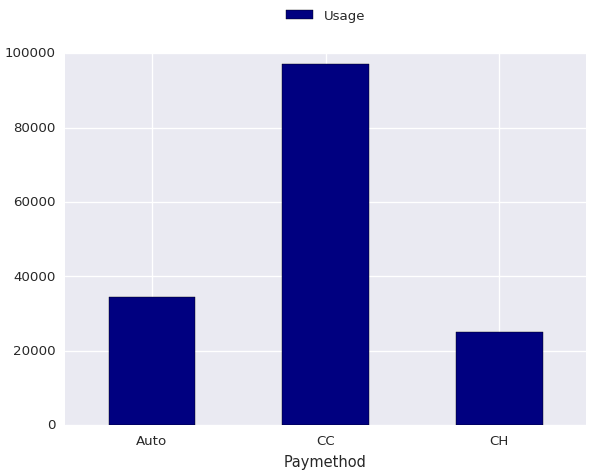

In [44]:
from pixiedust.display import *
display(data)

### Step 6: Build the Spark pipeline and the Random Forest model
"Pipeline" is an API in SparkML that's used for building models.
Additional information on SparkML: https://spark.apache.org/docs/2.0.2/ml-guide.html

In [18]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Prepare string variables so that they can be used by the decision tree algorithm
# StringIndexer encodes a string column of labels to a column of label indices
SI1 = StringIndexer(inputCol='Gender', outputCol='GenderEncoded')
SI2 = StringIndexer(inputCol='Status',outputCol='StatusEncoded')
SI3 = StringIndexer(inputCol='CarOwner',outputCol='CarOwnerEncoded')
SI4 = StringIndexer(inputCol='Paymethod',outputCol='PaymethodEncoded')
SI5 = StringIndexer(inputCol='LocalBilltype',outputCol='LocalBilltypeEncoded')
SI6 = StringIndexer(inputCol='LongDistanceBilltype',outputCol='LongDistanceBilltypeEncoded')

#encode the Label column
labelIndexer = StringIndexer(inputCol='CHURN', outputCol='label').fit(data)


# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["GenderEncoded", "StatusEncoded", "CarOwnerEncoded", "PaymethodEncoded", "LocalBilltypeEncoded", "LongDistanceBilltypeEncoded",\
                                       "Children", "EstIncome", "Age", "LongDistance", "International", "Local",\
                                       "Dropped","Usage","RatePlan"], outputCol="features")

In [19]:
# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

pipeline = Pipeline(stages=[SI1,SI2,SI3,SI4,SI5,SI6,labelIndexer, assembler, rf, labelConverter])

In [20]:
# Split data into train and test datasets
train, test = data.randomSplit([0.8,0.2], seed=6)
train.cache()
test.cache()

DataFrame[ID: int, Gender: string, Status: string, Children: double, EstIncome: double, CarOwner: string, Age: double, LongDistance: double, International: double, Local: double, Dropped: double, Paymethod: string, LocalBilltype: string, LongDistanceBilltype: string, Usage: double, RatePlan: double, CHURN: string]

In [21]:
# Build model. The fitted model from a Pipeline is a PipelineModel, which consists of fitted models and transformers, corresponding to the pipeline stages.
model = pipeline.fit(train)

### Plot predictors

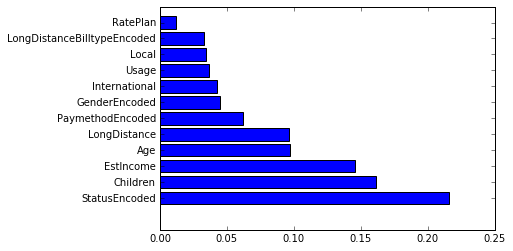

In [26]:

import matplotlib.pyplot as plt
## %matplotlib inline
import pandas as pd
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

vec_assem = model.stages[-3]
# input columns of vector assembler
feat = vec_assem.getInputCols()
# feature importance of input columns
tree = model.stages[-2]
featimpsc = tree.featureImportances.toArray()

fimp = pd.DataFrame(
    {'Features': feat,
     'Importance': featimpsc
    })
# features with importance that is non-zero
fimp = fimp[fimp.Importance > 0.01]
fimp = fimp.sort_values(by='Importance', ascending=False)

plt.barh(list(range(len(fimp))), fimp.Importance, align='center')
plt.yticks(list(range(len(fimp))), fimp.Features)
plt.show()

### Step 7: Score the test data set

In [12]:
results = model.transform(test)
results=results.select(results["ID"],results["CHURN"],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.toPandas().head(6)

,ID,CHURN,label,predictedLabel,prediction,probability
0,14,F,0,F,0,"[0.950664630167, 0.0493353698327]"
1,18,F,0,F,0,"[0.742965206751, 0.257034793249]"
2,21,F,0,F,0,"[0.645390363857, 0.354609636143]"
3,22,F,0,F,0,"[0.613449745089, 0.386550254911]"
4,29,T,1,T,1,"[0.318897922228, 0.681102077772]"
5,40,T,1,T,1,"[0.21778202071, 0.78221797929]"


### Step 8: Model Evaluation 

In [13]:
print 'Precision model1 = {:.2f}.'.format(results.filter(results.label == results.prediction).count() / float(results.count()))

Precision model1 = 0.90.


In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print 'Area under ROC curve = {:.2f}.'.format(evaluator.evaluate(results))

Area under ROC curve = 0.89.


We have finished building and testing a predictive model. The next step is to deploy it for real time scoring. 

### Step 9: Persist model

In this section you will learn how to store your pipeline and model in Watson Machine Learning repository by using python client libraries.

First, you must import client libraries.

**Note**: Apache® Spark 2.0 or higher is required.

In [15]:
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

Authenticate to Watson Machine Learning service on Bluemix.

**Action**: Put authentication information from your instance of Watson Machine Learning service here.</div>

In [16]:
wml_credentials={
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "X76Yu8/fV526oP70L7tQ38+kReWmaFiXJmruwas0z0Kxw13lGFyPu/tsKh3P0I5IHxGxQ3pIogjgEOjN0TGDTcL0h32gVzPkwMbmHXNpi+FQYUqQmv73SQJrb1WXWeZv",
  "username": "65a3184a-73f1-4619-830b-67fdade086f8",
  "password": "70f9d64b-a157-4f9b-a1f8-be77092748a5",
  "instance_id": "e4e074bd-fed8-45c3-af30-abaede0466f8"
}

**Tip**: `wml_service_path`, user and `wml_password` can be found on **Service Credentials** tab of service instance created in Bluemix. If you cannot see **instance_id** field in **Serice Credentials** generate new credentials by pressing **New credential (+)** button. 

In [17]:
ml_repository_client = MLRepositoryClient(wml_credentials['url'])
ml_repository_client.authorize(wml_credentials['username'], wml_credentials['password'])

Create model artifact (abstraction layer).

In [ ]:
model_artifact = MLRepositoryArtifact(model, training_data=train, name="Telco Churn Prediction")

**Tip**: The MLRepositoryArtifact method expects a trained model object, training data, and a model name. (It is this model name that is displayed by the Watson Machine Learning service).

### Step 10: Save pipeline and model

In this subsection you will learn how to save pipeline and model artifacts to your Watson Machine Learning instance.

In [21]:
saved_model = ml_repository_client.models.save(model_artifact)

Get saved model metadata from Watson Machine Learning.

**Tip**: Use *meta.available_props()* to get the list of available props.

In [22]:
saved_model.meta.available_props()

['inputDataSchema',
 'evaluationMetrics',
 'pipelineVersionHref',
 'modelVersionHref',
 'trainingDataRef',
 'pipelineType',
 'creationTime',
 'lastUpdated',
 'label',
 'authorEmail',
 'trainingDataSchema',
 'authorName',
 'version',
 'modelType',
 'runtime',
 'evaluationMethod']

In [23]:
print "modelType: " + saved_model.meta.prop("modelType")
print "trainingDataSchema: " + str(saved_model.meta.prop("trainingDataSchema"))
print "creationTime: " + str(saved_model.meta.prop("creationTime"))
print "modelVersionHref: " + saved_model.meta.prop("modelVersionHref")
print "label: " + saved_model.meta.prop("label")

modelType: sparkml-model-2.1
trainingDataSchema: {u'fields': [{u'nullable': True, u'type': u'integer', u'name': u'ID', u'metadata': {}}, {u'nullable': True, u'type': u'string', u'name': u'Gender', u'metadata': {}}, {u'nullable': True, u'type': u'string', u'name': u'Status', u'metadata': {}}, {u'nullable': True, u'type': u'double', u'name': u'Children', u'metadata': {}}, {u'nullable': True, u'type': u'double', u'name': u'EstIncome', u'metadata': {}}, {u'nullable': True, u'type': u'string', u'name': u'CarOwner', u'metadata': {}}, {u'nullable': True, u'type': u'double', u'name': u'Age', u'metadata': {}}, {u'nullable': True, u'type': u'double', u'name': u'LongDistance', u'metadata': {}}, {u'nullable': True, u'type': u'double', u'name': u'International', u'metadata': {}}, {u'nullable': True, u'type': u'double', u'name': u'Local', u'metadata': {}}, {u'nullable': True, u'type': u'double', u'name': u'Dropped', u'metadata': {}}, {u'nullable': True, u'type': u'string', u'name': u'Paymethod', u'm

**Tip**: **modelVersionHref** is our model unique indentifier in the Watson Machine Learning repository.

### Step 11: Load model

In this subsection you will learn how to load back saved model from specified instance of Watson Machine Learning.

In [24]:
loadedModelArtifact = ml_repository_client.models.get(saved_model.uid)

You can print for example model name to make sure that model has been loaded correctly.

In [25]:
print str(loadedModelArtifact.name)

Telco Churn Prediction


As you can see the name is correct. You have already learned how save and load the model from Watson Machine Learning repository.

In [26]:
m = loadedModelArtifact.model_instance()

In [27]:
m.stages

[StringIndexer_4c5788a497f2e7733c91,
 StringIndexer_47dfab81b599a69b315b,
 StringIndexer_4d7581e73a6658f4eca2,
 StringIndexer_4f9bb2fd5cc686e7495c,
 StringIndexer_453288faaf5ca7494d9e,
 StringIndexer_46adbfef7de917e325d1,
 StringIndexer_472c80f15e009af93b97,
 VectorAssembler_41c3ad0f167217f6a19e,
 RandomForestClassificationModel (uid=rfc_bbf77f66c1bf) with 20 trees,
 IndexToString_401ca2c9a8e8ffdc6d35]

In [28]:
type(m.stages[1])

pyspark.ml.feature.StringIndexerModel

<a id="scoring"></a>
### Step 12: Deploy and score in a Cloud

In this section you will learn how to create online scoring and to score a new data record by using the Watson Machine Learning REST API. 
For more information about REST APIs, see the [Swagger Documentation](http://watson-ml-api.mybluemix.net/).

To work with the Watson Machine Leraning REST API you must generate an access token. To do that you can use the following sample code:

In [29]:
import urllib3, requests, json

headers = urllib3.util.make_headers(basic_auth='{username}:{password}'.format(username=wml_credentials['username'], password=wml_credentials['password']))
url = '{}/v3/identity/token'.format(wml_credentials['url'])
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')

#### Create online scoring endpoint

Now you can create an online scoring endpoint. 

#### Get published_models url from instance details

In [30]:
endpoint_instance = wml_credentials['url'] + "/v3/wml_instances/" + wml_credentials['instance_id']
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

response_get_instance = requests.get(endpoint_instance, headers=header)

print response_get_instance
print response_get_instance.text

<Response [200]>
{"metadata":{"guid":"e4e074bd-fed8-45c3-af30-abaede0466f8","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/e4e074bd-fed8-45c3-af30-abaede0466f8","created_at":"2017-07-03T13:38:37.078Z","modified_at":"2017-10-09T16:47:30.947Z"},"entity":{"source":"Bluemix","published_models":{"url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/e4e074bd-fed8-45c3-af30-abaede0466f8/published_models"},"usage":{"expiration_date":"2017-11-01T00:00:00.000Z","computation_time":{"limit":18000,"current":0},"model_count":{"limit":200,"current":8},"prediction_count":{"limit":5000,"current":0},"deployment_count":{"limit":5,"current":3}},"plan_id":"3f6acf43-ede8-413a-ac69-f8af3bb0cbfe","status":"Active","organization_guid":"d1401550-92eb-403d-bdcf-6fba69bba2f2","region":"us-south","account":{"id":"dcc36ed0250ce6b62e51beb7c80b8df3","name":"Michael Heusch's Account","type":"TRIAL"},"owner":{"ibm_id":"310001BM95","email":"mheusch2@uk.ibm.com","user_id":"d1306ffb-fa46-4343-9755-7f9cc

In [33]:
endpoint_published_models = json.loads(response_get_instance.text).get('entity').get('published_models').get('url')

print endpoint_published_models

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/e4e074bd-fed8-45c3-af30-abaede0466f8/published_models


Execute the following sample code that uses the published_models endpoint to get deployments url.

#### Get the list of published models

In [35]:
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

response_get = requests.get(endpoint_published_models, headers=header)

print response_get
print response_get.text

<Response [200]>
{"count":1,"resources":[{"metadata":{"guid":"f4fe3a2f-d9f0-4ae2-b5af-ec936638010d","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/e4e074bd-fed8-45c3-af30-abaede0466f8/published_models/f4fe3a2f-d9f0-4ae2-b5af-ec936638010d","created_at":"2017-10-09T16:47:30.710Z","modified_at":"2017-10-09T16:47:30.921Z"},"entity":{"runtime_environment":"spark-2.1","author":{},"name":"Telco Churn Prediction","label_col":"CHURN","training_data_schema":{"fields":[{"metadata":{},"type":"integer","name":"ID","nullable":true},{"metadata":{},"type":"string","name":"Gender","nullable":true},{"metadata":{},"type":"string","name":"Status","nullable":true},{"metadata":{},"type":"double","name":"Children","nullable":true},{"metadata":{},"type":"double","name":"EstIncome","nullable":true},{"metadata":{},"type":"string","name":"CarOwner","nullable":true},{"metadata":{},"type":"double","name":"Age","nullable":true},{"metadata":{},"type":"double","name":"LongDistance","nullable":true},{"met

#### Get published model deployment url

In [36]:
[endpoint_deployments] = [x.get('entity').get('deployments').get('url') for x in json.loads(response_get.text).get('resources') if x.get('metadata').get('guid') == saved_model.uid]

print endpoint_deployments

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/e4e074bd-fed8-45c3-af30-abaede0466f8/published_models/f4fe3a2f-d9f0-4ae2-b5af-ec936638010d/deployments


#### Create online deployment for published model

In [37]:
payload_online = {"name": "Product Line Prediction", "description": "My Cool Deployment", "type": "online"}
response_online = requests.post(endpoint_deployments, json=payload_online, headers=header)

print response_online
print response_online.text

<Response [201]>
{"metadata":{"guid":"256ba905-4dc7-486f-bc34-2120bce470ab","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/e4e074bd-fed8-45c3-af30-abaede0466f8/published_models/f4fe3a2f-d9f0-4ae2-b5af-ec936638010d/deployments/256ba905-4dc7-486f-bc34-2120bce470ab","created_at":"2017-10-09T17:00:07.763Z","modified_at":"2017-10-09T17:00:18.843Z"},"entity":{"runtime_environment":"spark-2.1","name":"Product Line Prediction","scoring_url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/e4e074bd-fed8-45c3-af30-abaede0466f8/published_models/f4fe3a2f-d9f0-4ae2-b5af-ec936638010d/deployments/256ba905-4dc7-486f-bc34-2120bce470ab/online","description":"My Cool Deployment","published_model":{"author":{},"name":"Telco Churn Prediction","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/e4e074bd-fed8-45c3-af30-abaede0466f8/published_models/f4fe3a2f-d9f0-4ae2-b5af-ec936638010d","guid":"f4fe3a2f-d9f0-4ae2-b5af-ec936638010d","created_at":"2017-10-09T17:00:07.737Z"},"model_type

In [50]:
scoring_url = json.loads(response_online.text).get('entity').get('scoring_url')
print scoring_url

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/e4e074bd-fed8-45c3-af30-abaede0466f8/published_models/f4fe3a2f-d9f0-4ae2-b5af-ec936638010d/deployments/256ba905-4dc7-486f-bc34-2120bce470ab/online


Now, you can send (POST) new scoring records (new data) for which you would like to get predictions. To do that, execute the following sample code: 

In [39]:
payload_scoring = {"fields": ["Gender","Status","Children","EstIncome","CarOwner","Age","LongDistance","International","Local","Dropped","Paymethod","LocalBilltype","LongDistanceBilltype","Usage","RatePlan"],\
                   "values": [["F","S",1.000000,38000.000000,"N",24.393333,23.560000,0.000000,206.080000,0.000000,"CC","Budget","Intnl_discount",229.640000,3.000000]]}
response_scoring = requests.post(scoring_url, json=payload_scoring, headers=header)

print response_scoring.text

{
  "fields": ["Gender", "Status", "Children", "EstIncome", "CarOwner", "Age", "LongDistance", "International", "Local", "Dropped", "Paymethod", "LocalBilltype", "LongDistanceBilltype", "Usage", "RatePlan", "CHURN", "GenderEncoded", "StatusEncoded", "CarOwnerEncoded", "PaymethodEncoded", "LocalBilltypeEncoded", "LongDistanceBilltypeEncoded", "label", "features", "rawPrediction", "probability", "prediction", "predictedLabel"],
  "values": [["F", "S", 1.0, 38000.0, "N", 24.393333, 23.56, 0.0, 206.08, 0.0, "CC", "Budget", "Intnl_discount", 229.64, 3.0, "F", 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 38000.0, 24.393333, 23.56, 0.0, 206.08, 0.0, 229.64, 3.0], [1.6658053320448967, 18.334194667955103], [0.08329026660224484, 0.9167097333977552], 1.0, "T"]]
}


## Summary

 You successfully completed this notebook! You learned how to use Apache Spark machine learning as well as Watson Machine Learning for model creation and deployment. Check out our _[Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/pm_service_api_spark.html)_ for more samples, tutorials, documentation, how-tos, and blog posts. 